In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pySankey.sankey import sankey
import plotly.graph_objects as go
import plotly.io as pio

palette = sns.color_palette("colorblind")
sns.set_palette(palette)

In [2]:
df = pd.read_csv('dataset_doc_quant_data_final.csv')
print(f"Dataset shape: {df.shape}")
print(f"Number of entries: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("Column names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
df.head()

Dataset shape: (59, 13)
Number of entries: 59
Number of features: 13
Column names:
['name', 'authors', 'year', 'prior_user_research', 'If study was used, type of study used', 'audiences', 'stakeholders_mentioned', 'stakeholders_involved', 'What is the precise context of use of the tool as presented by authors\n', 'tool_evaluation', 'degree_automation', 'tool_integration', 'tool_description']

Data types:
name                                                                        object
authors                                                                     object
year                                                                         int64
prior_user_research                                                         object
If study was used, type of study used                                       object
audiences                                                                   object
stakeholders_mentioned                                                      object
stakeholder

,name,authors,year,prior_user_research,"If study was used, type of study used",audiences,stakeholders_mentioned,stakeholders_involved,What is the precise context of use of the tool as presented by authors\n,tool_evaluation,degree_automation,tool_integration,tool_description
0,Data Statements | Tech Policy Lab,"McMillan-Major, Angelina; Bender, Emily M.",2023,No,This paper is about Data Statements version 3\...,"dataset creators, dataset users",Yes,No,linguistic contexts primarily but could be bro...,No,Manual,No,toolkit
1,The Dataset Nutrition Label: A Framework To Dr...,"Holland, Sarah; Hosny, Ahmed; Newman, Sarah; J...",2018,Yes,I am saying yes even though the study was not ...,dataset creators,Yes,Yes,Their intention overall is to be context-indep...,No,Hybrid,No,framework
2,Towards accountability for machine learning da...,"Hutchinson, Ben; Smart, Andrew; Hanna, Alex; D...",2021,No,NaN,dataset creators,Yes,No,"Artificial Ingeligence, \nMachine Learning dat...",No,Manual,No,framework
3,Understanding machine learning practitioners' ...,"Heger, Amy K.; Marquis, Liz B.; Vorvoreanu, Mi...",2022,NaN,This is a n empirical study of existing datase...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,study
4,A generative benchmark creation framework for ...,"Fox, Daniel C.; Khatiwada, Aamod; Shraga, Roee",2024,No,NaN,dataset creators,No,No,"No precise context is described, there are onl...",No,Automated,No,framework


# Figure 1: Type of tool, automation, years

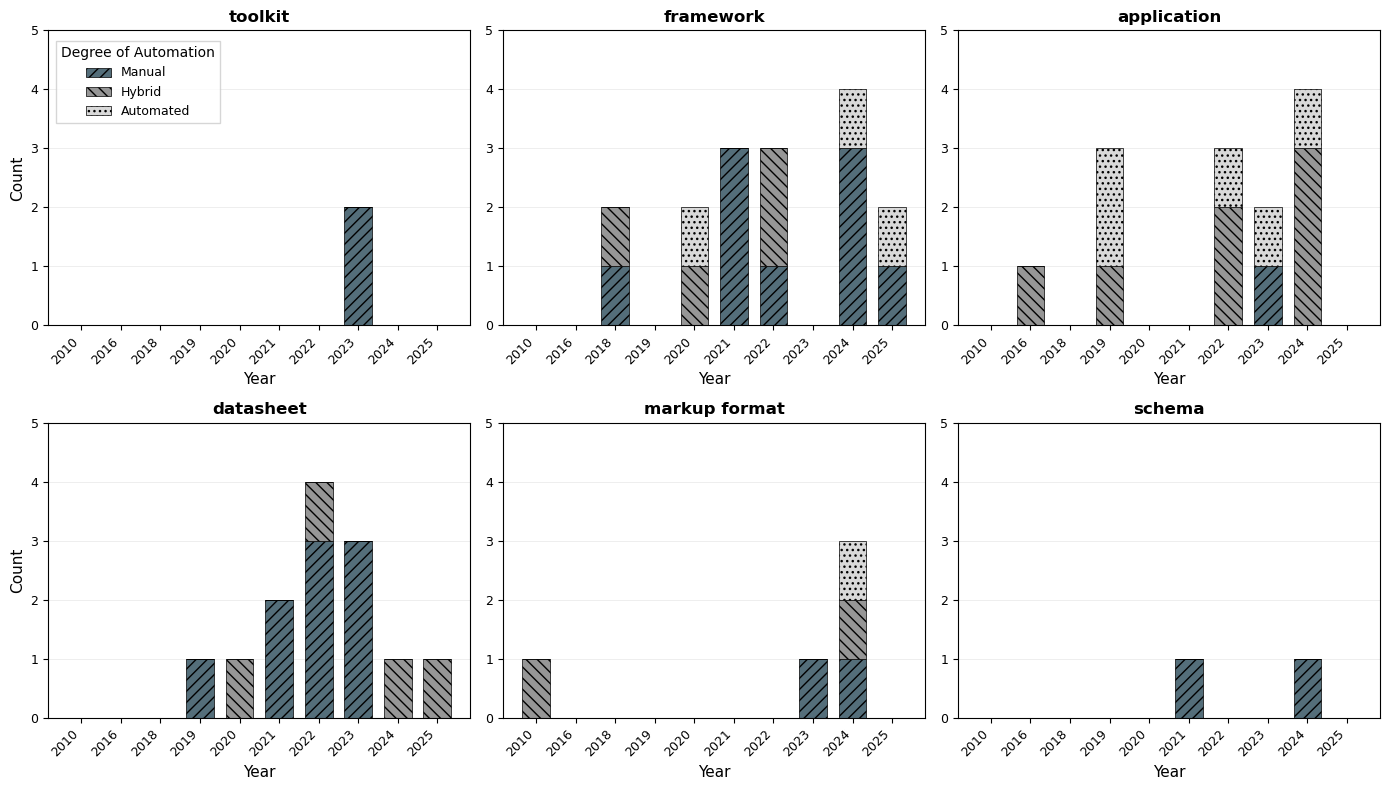

In [21]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

tool_descriptions = df_filtered['tool_description'].dropna().unique()
automation_degrees = df_filtered['degree_automation'].dropna().unique()
years = sorted(df_filtered['year'].dropna().unique())

# Define accessible colors (from Sankey diagram) and hatch patterns
automation_styles = {
    'Manual': {'color': '#546e7a', 'hatch': '///'},      # Medium-dark blue-gray with forward diagonal
    'Hybrid': {'color': '#969696', 'hatch': '\\\\\\'},   # Medium gray with backward diagonal
    'Automated': {'color': '#d9d9d9', 'hatch': '...'}    # Light gray with dots
}

max_count = 0
for tool in tool_descriptions:
    tool_data = df_filtered[df_filtered['tool_description'] == tool]
    if len(tool_data) > 0:
        counts = tool_data.groupby('year').size()
        max_count = max(max_count, counts.max() if len(counts) > 0 else 0)

n_tools = len(tool_descriptions)
n_cols = 3
n_rows = (n_tools + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for idx, tool in enumerate(tool_descriptions):
    ax = axes[idx]

    tool_data = df_filtered[df_filtered['tool_description'] == tool]

    if len(tool_data) > 0:
        count_data = tool_data.groupby(['year', 'degree_automation']).size().unstack(fill_value=0)

        # Reindex to include all years from the full dataset
        count_data = count_data.reindex(years, fill_value=0)

        for degree in automation_degrees:
            if degree not in count_data.columns:
                count_data[degree] = 0

        if not count_data.empty:
            # Plot stacked bars manually to add both color and hatching
            bottom = np.zeros(len(count_data))
            x_pos = np.arange(len(count_data))

            for degree in ['Manual', 'Hybrid', 'Automated']:  # Ensure consistent order
                if degree in count_data.columns:
                    bars = ax.bar(x_pos, count_data[degree], bottom=bottom,
                                width=0.7,
                                color=automation_styles[degree]['color'],
                                edgecolor='black',
                                linewidth=0.5,
                                hatch=automation_styles[degree]['hatch'],
                                label=degree)
                    bottom += count_data[degree].values

            ax.set_xticks(x_pos)
            ax.set_xticklabels(count_data.index, rotation=45, ha='right')
        else:
            ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                    ha='center', va='center', fontsize=10, color='gray')
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', fontsize=10, color='gray')

    ax.set_title(f'{tool}', fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count' if idx % 3 == 0 else '')

    ax.set_ylim(0, max_count + 1)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, min_n_ticks=max_count+1))

    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

for idx in range(n_tools, len(axes)):
    axes[idx].set_visible(False)

# Create legend with both accessible colors and hatching
legend_elements = [
    plt.Rectangle((0,0), 1, 1,
                facecolor=automation_styles['Manual']['color'],
                hatch=automation_styles['Manual']['hatch'],
                edgecolor='black', linewidth=0.5, label='Manual'),
    plt.Rectangle((0,0), 1, 1,
                facecolor=automation_styles['Hybrid']['color'],
                hatch=automation_styles['Hybrid']['hatch'],
                edgecolor='black', linewidth=0.5, label='Hybrid'),
    plt.Rectangle((0,0), 1, 1,
                facecolor=automation_styles['Automated']['color'],
                hatch=automation_styles['Automated']['hatch'],
                edgecolor='black', linewidth=0.5, label='Automated')
]

fig.legend(handles=legend_elements, title='Degree of Automation',
        loc='upper right', bbox_to_anchor=(0.165, 0.95),
        frameon=True, fancybox=False)

plt.tight_layout()
plt.savefig("fig_2_type_of_tool_automation_over_time.png", dpi=300)
plt.show()

# Figure 2. Tool evaluation and integration across different types of tools

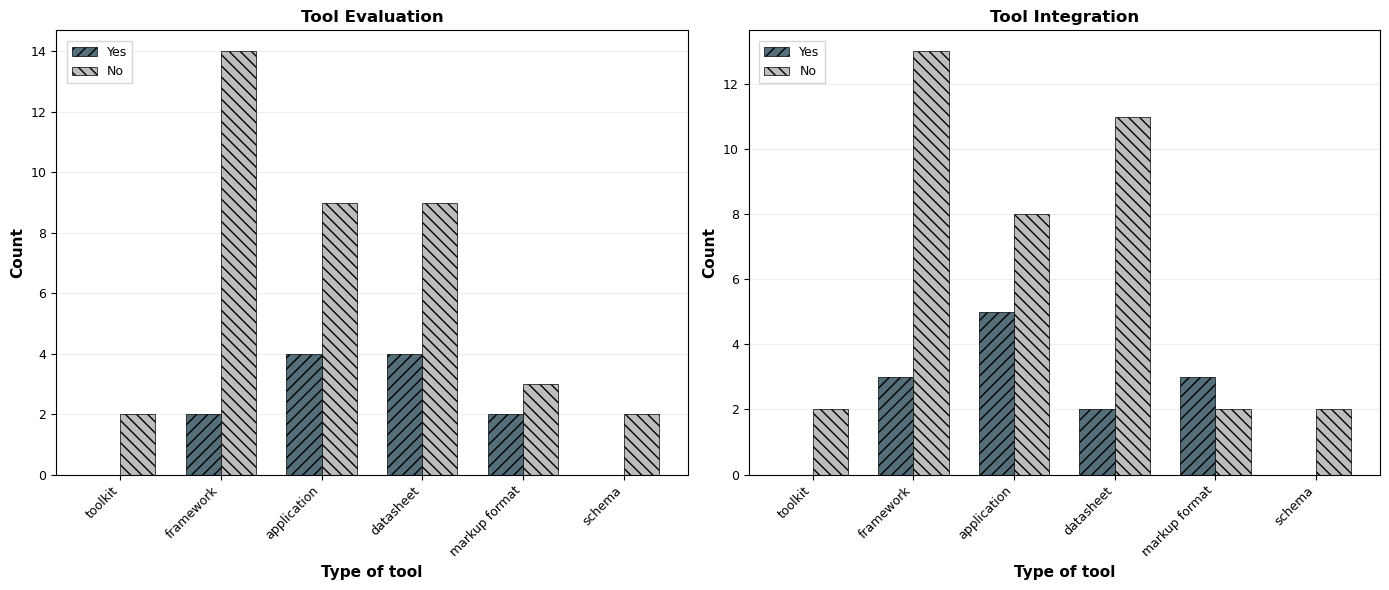

In [28]:
plt.rcParams['font.size'] = 10

plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

tool_descriptions = df_filtered['tool_description'].dropna().unique()

eval_yes = []
eval_no = []
integ_yes = []
integ_no = []

for tool in tool_descriptions:
    tool_data = df_filtered[df_filtered['tool_description'] == tool]
    eval_yes.append((tool_data['tool_evaluation'] == 'Yes').sum())
    eval_no.append((tool_data['tool_evaluation'] == 'No').sum())
    integ_yes.append((tool_data['tool_integration'] == 'Yes').sum())
    integ_no.append((tool_data['tool_integration'] == 'No').sum())

# Define accessible colors and hatch patterns for Yes/No
response_styles = {
    'Yes': {'color': '#546e7a', 'hatch': '///'},     # Medium-dark blue-gray with forward diagonal
    'No': {'color': '#bdbdbd', 'hatch': '\\\\\\'}    # Light gray with backward diagonal
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(tool_descriptions))
width = 0.35

# Tool Evaluation subplot
bars1 = ax1.bar(x - width/2, eval_yes, width, label='Yes',
                color=response_styles['Yes']['color'],
                hatch=response_styles['Yes']['hatch'],
                edgecolor='black', linewidth=0.5)
bars2 = ax1.bar(x + width/2, eval_no, width, label='No',
                color=response_styles['No']['color'],
                hatch=response_styles['No']['hatch'],
                edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Type of tool', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Tool Evaluation', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(tool_descriptions, rotation=45, ha='right')
ax1.legend(frameon=True, fancybox=False,
            loc='upper right', bbox_to_anchor=(0.13, 0.99))
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Tool Integration subplot
bars3 = ax2.bar(x - width/2, integ_yes, width, label='Yes',
                color=response_styles['Yes']['color'],
                hatch=response_styles['Yes']['hatch'],
                edgecolor='black', linewidth=0.5)
bars4 = ax2.bar(x + width/2, integ_no, width, label='No',
                color=response_styles['No']['color'],
                hatch=response_styles['No']['hatch'],
                edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Type of tool', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Tool Integration', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(tool_descriptions, rotation=45, ha='right')
ax2.legend(frameon=True, fancybox=False,
            loc='upper right', bbox_to_anchor=(0.13, 0.99))
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("fig_2_evaluation_and_integration_across_tools.png", dpi=300)
plt.show()

# Figure 3. Appearance of different types of tools across the years

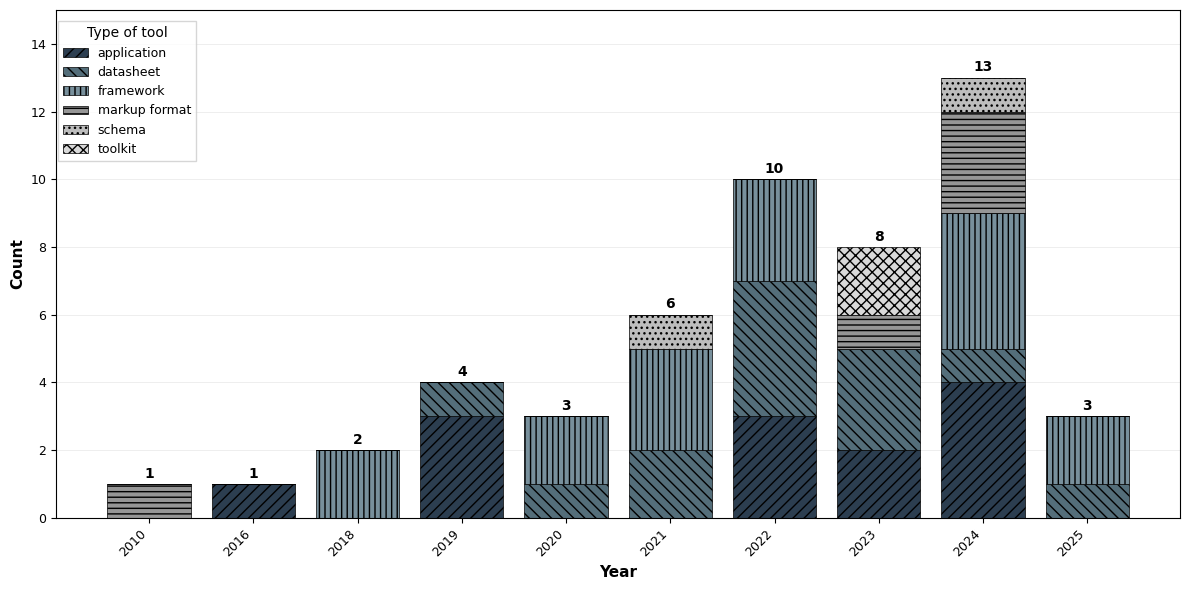

In [22]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

yearly_counts = df_filtered.groupby(['year', 'tool_description']).size().unstack(fill_value=0)
yearly_totals = yearly_counts.sum(axis=1)

# Define accessible colors and hatch patterns for 6 tool types
tool_styles = {
    'application': {'color': '#2c3e50', 'hatch': '///'},      # Very dark with forward diagonal
    'datasheet': {'color': '#546e7a', 'hatch': '\\\\\\'},     # Dark blue-gray with backward diagonal
    'framework': {'color': '#78909c', 'hatch': '|||'},        # Medium blue-gray with vertical lines
    'markup format': {'color': '#969696', 'hatch': '---'},    # Medium gray with horizontal lines
    'schema': {'color': '#bdbdbd', 'hatch': '...'},           # Light gray with dots
    'toolkit': {'color': '#d9d9d9', 'hatch': 'xxx'}           # Very light gray with crosshatch
}

fig, ax = plt.subplots(figsize=(12, 6))

# Plot stacked bars manually to add both color and hatching
bottom = np.zeros(len(yearly_counts))
x_pos = np.arange(len(yearly_counts))

# Ensure consistent order matching the dictionary
tool_order = ['application', 'datasheet', 'framework', 'markup format', 'schema', 'toolkit']

for tool in tool_order:
    if tool in yearly_counts.columns:
        bars = ax.bar(x_pos, yearly_counts[tool], bottom=bottom,
                    width=0.8,
                    color=tool_styles[tool]['color'],
                    edgecolor='black',
                    linewidth=0.5,
                    hatch=tool_styles[tool]['hatch'],
                    label=tool)
        bottom += yearly_counts[tool].values

# Add total count labels on top of bars
for i, (year, total) in enumerate(yearly_totals.items()):
    ax.text(i, total + 0.1, str(int(total)),
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(yearly_counts.index, rotation=45, ha='right')
ax.legend(title='Type of tool', frameon=True, fancybox=False,
        loc='upper right', bbox_to_anchor=(0.13, 0.99))
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylim(0, yearly_totals.max() + 2)

plt.tight_layout()
plt.savefig("fig_1_different_tools_over_time.png", dpi=300)
plt.show()

# Figure 4. Distribution of types of proposals in relation to audiences

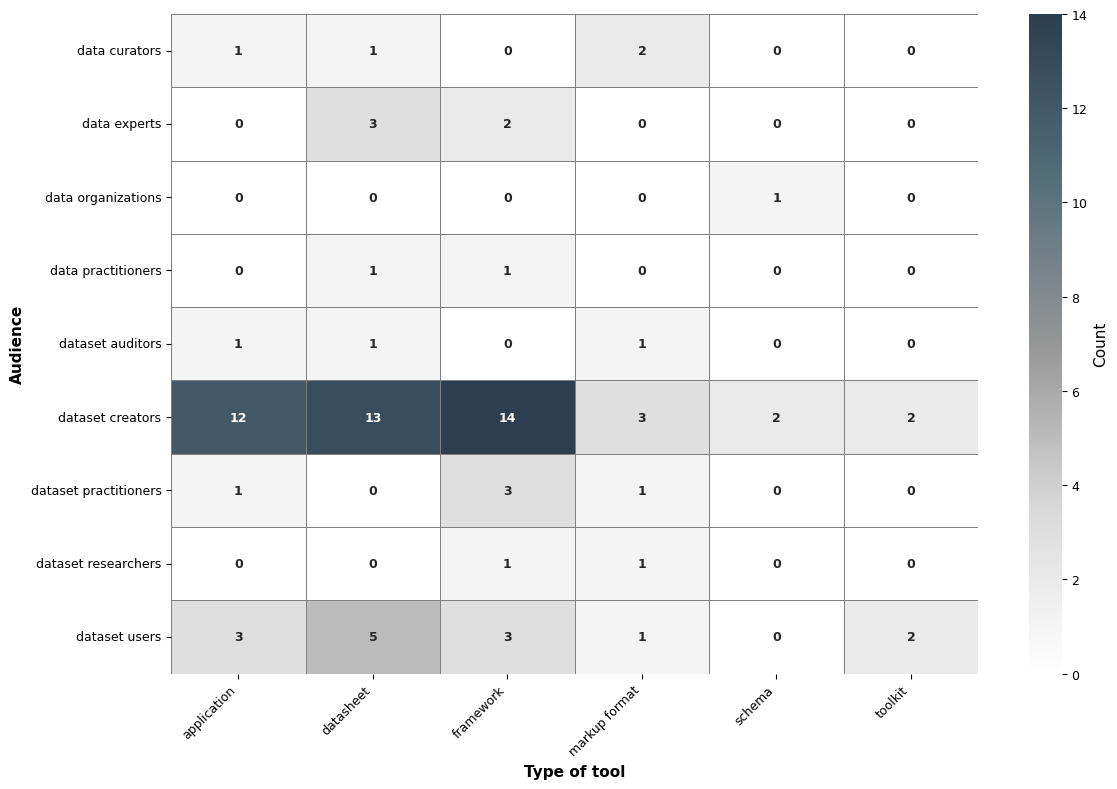

In [29]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

audience_list = []
for idx, row in df_filtered.iterrows():
    if pd.notna(row['audiences']):
        audiences = [a.strip() for a in str(row['audiences']).split(',')]
        for audience in audiences:
            audience_list.append({'tool_description': row['tool_description'],
                                'audience': audience})

audience_df = pd.DataFrame(audience_list)
if not audience_df.empty:
    audience_matrix = pd.crosstab(audience_df['audience'], audience_df['tool_description'])
else:
    audience_matrix = pd.DataFrame()

fig, ax = plt.subplots(figsize=(12, 8))

if not audience_matrix.empty:
    # Use accessible grayscale colormap from white to dark blue-gray
    cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
        "accessible_gray",
        ["white", "#d9d9d9", "#969696", "#546e7a", "#2c3e50"]
    )

    sns.heatmap(audience_matrix, annot=True, fmt='d', cmap=cmap,
                cbar_kws={'label': 'Count'},
                linewidths=0.5, linecolor='gray',
                annot_kws={'fontsize': 9, 'fontweight': 'bold'},
                ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_xlabel('Type of tool', fontweight='bold')
ax.set_ylabel('Audience', fontweight='bold')

plt.tight_layout()
plt.savefig("fig_4_distribution_tool_type_across_audiences.png", dpi=300)
plt.show()

# Figure 5. Distribution of level of automation of tools over time

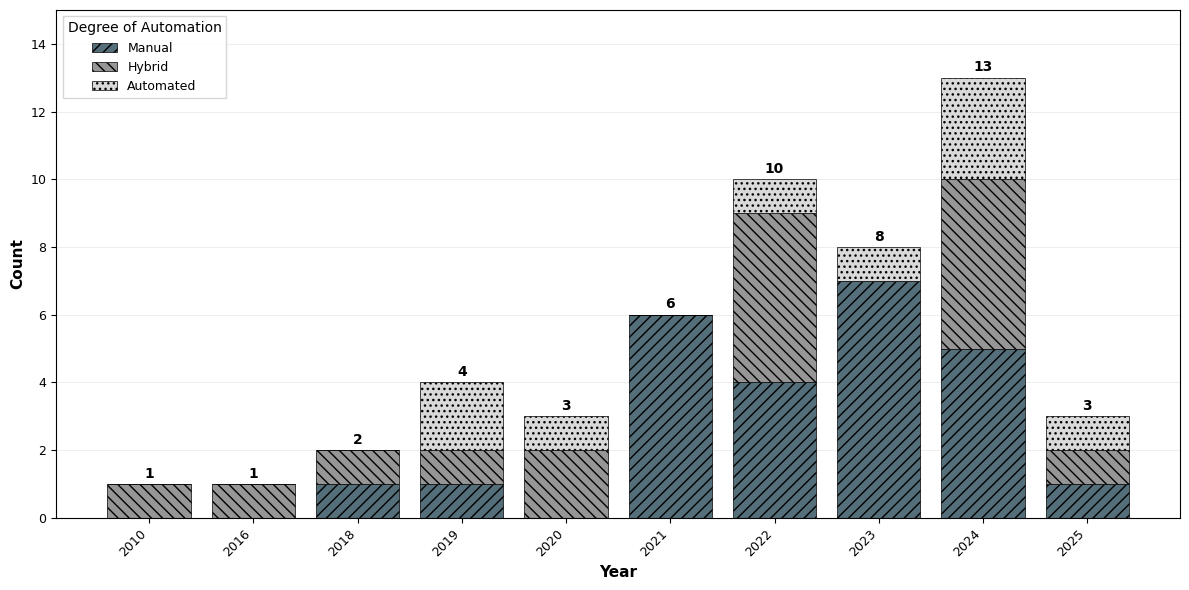

In [26]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

automation_yearly = df_filtered.groupby(['year', 'degree_automation']).size().unstack(fill_value=0)

automation_order = ['Manual', 'Hybrid', 'Automated']

# Define accessible colors and hatch patterns (same as Figure 1)
automation_styles = {
    'Manual': {'color': '#546e7a', 'hatch': '///'},      # Medium-dark blue-gray with forward diagonal
    'Hybrid': {'color': '#969696', 'hatch': '\\\\\\'},   # Medium gray with backward diagonal
    'Automated': {'color': '#d9d9d9', 'hatch': '...'}    # Light gray with dots
}

for degree in automation_order:
    if degree not in automation_yearly.columns:
        automation_yearly[degree] = 0
automation_yearly = automation_yearly[automation_order]

yearly_totals = automation_yearly.sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot stacked bars manually to add both color and hatching
bottom = np.zeros(len(automation_yearly))
x_pos = np.arange(len(automation_yearly))

for degree in automation_order:
    if degree in automation_yearly.columns:
        bars = ax.bar(x_pos, automation_yearly[degree], bottom=bottom,
                    width=0.8,
                    color=automation_styles[degree]['color'],
                    edgecolor='black',
                    linewidth=0.5,
                    hatch=automation_styles[degree]['hatch'],
                    label=degree)
        bottom += automation_yearly[degree].values

# Add total count labels on top of bars
for i, (year, total) in enumerate(yearly_totals.items()):
    ax.text(i, total + 0.1, str(int(total)),
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(automation_yearly.index, rotation=45, ha='right')
ax.legend(title='Degree of Automation', frameon=True, fancybox=False)
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylim(0, yearly_totals.max() + 2)

plt.tight_layout()
plt.savefig("fig_5_distribution_of_automation_over_time.png", dpi=300)
plt.show()

# Figure 6. Types of tools per audience, per year

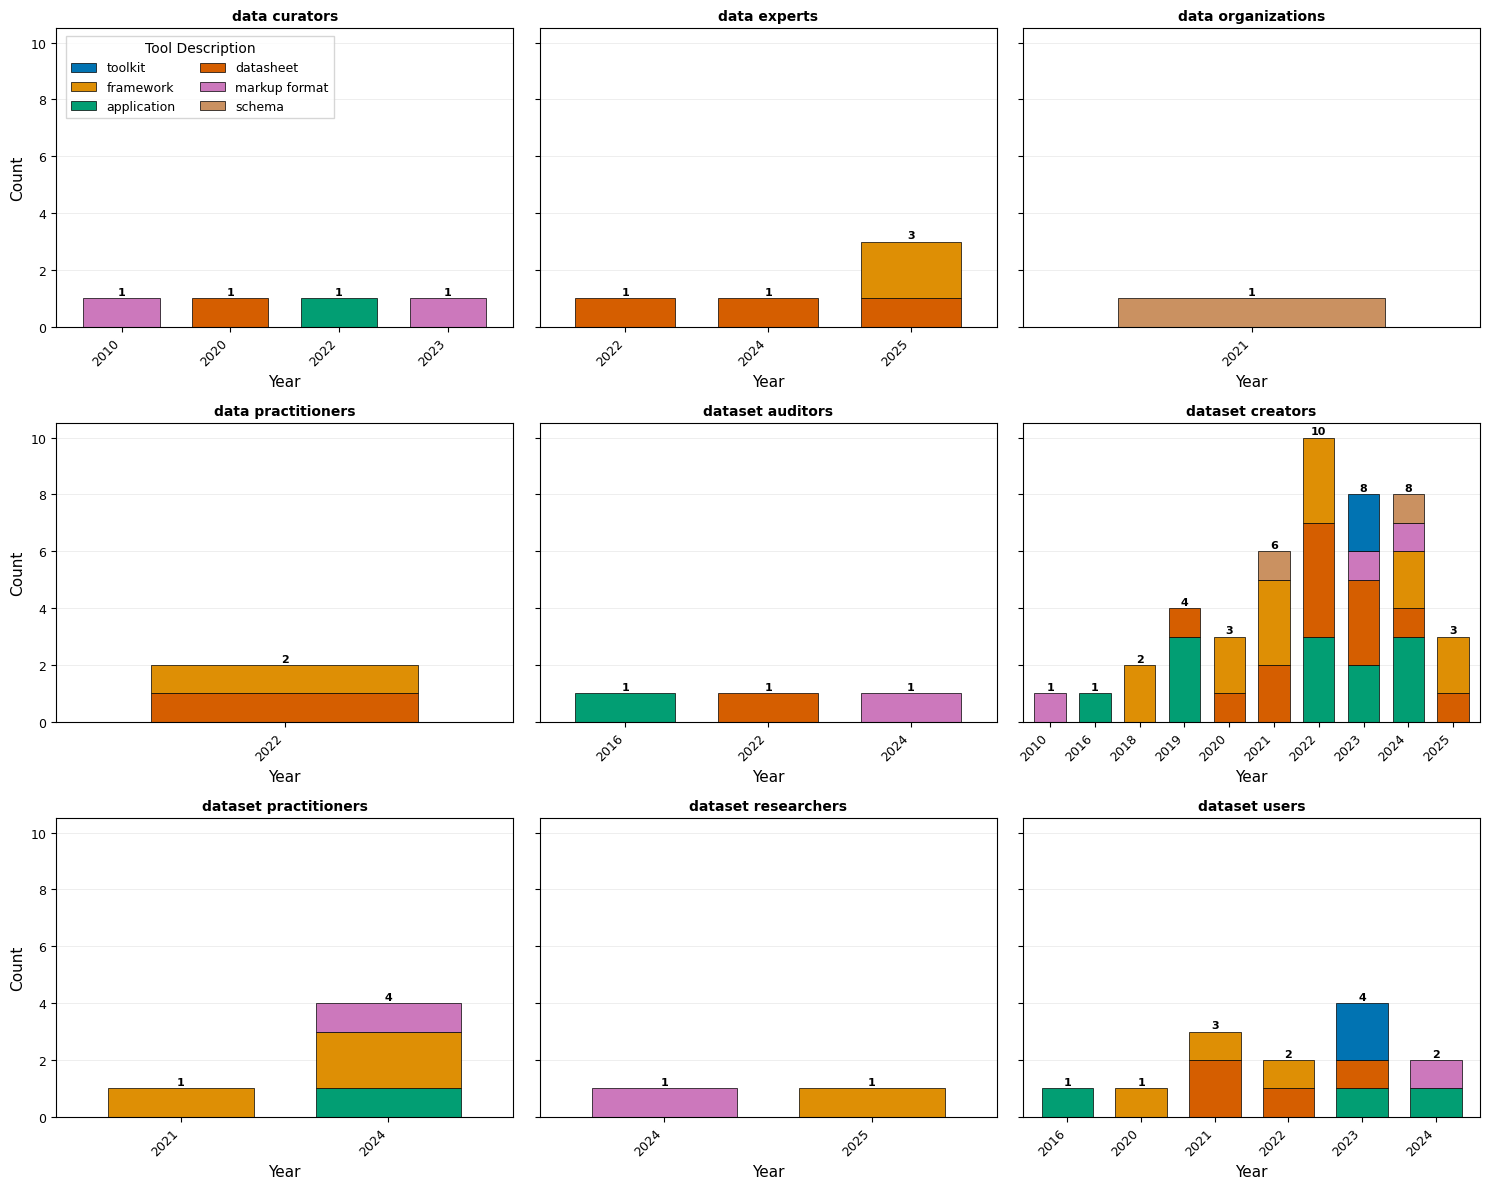

In [8]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']

audience_set = set()
for audiences in df_filtered['audiences'].dropna():
    for audience in str(audiences).split(','):
        audience_set.add(audience.strip())

audience_list = sorted(list(audience_set))

n_audiences = len(audience_list)
n_cols = 3
n_rows = (n_audiences + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharey=True)
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

tool_descriptions = df_filtered['tool_description'].dropna().unique()
tool_colors = dict(zip(tool_descriptions, sns.color_palette("colorblind", n_colors=len(tool_descriptions))))

for idx, audience in enumerate(audience_list):
    ax = axes[idx]

    audience_data = []
    for _, row in df_filtered.iterrows():
        if pd.notna(row['audiences']) and audience in str(row['audiences']):
            audience_data.append(row)

    if audience_data:
        audience_df = pd.DataFrame(audience_data)

        counts = audience_df.groupby(['year', 'tool_description']).size().unstack(fill_value=0)

        counts.plot(kind='bar', stacked=True, ax=ax,
                    color=[tool_colors.get(col, 'gray') for col in counts.columns],
                    edgecolor='black', linewidth=0.5, width=0.7, legend=False)

        yearly_totals = counts.sum(axis=1)
        for i, total in enumerate(yearly_totals):
            if total > 0:
                ax.text(i, total + 0.05, str(int(total)),
                        ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', fontsize=10, color='gray')

    display_audience = audience if len(audience) <= 25 else audience[:22] + '...'
    ax.set_title(f'{display_audience}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count' if idx % n_cols == 0 else '')
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for idx in range(n_audiences, len(axes)):
    axes[idx].set_visible(False)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=tool_colors[tool],
                                edgecolor='black', linewidth=0.5, label=tool)
                for tool in tool_descriptions]
fig.legend(handles=legend_elements, title='Tool Description',
        loc='upper right', bbox_to_anchor=(0.230, 0.97),
        frameon=True, fancybox=False, ncol=2)

#   fig.suptitle('Types of tools per audience over time',
#               fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig("fig_6_types_of_tools_by_audience_over_time.png")
plt.show()

# Figure 7. Analysis of stakeholders mentioned vs. involved and integration efforts within stakeholders involved

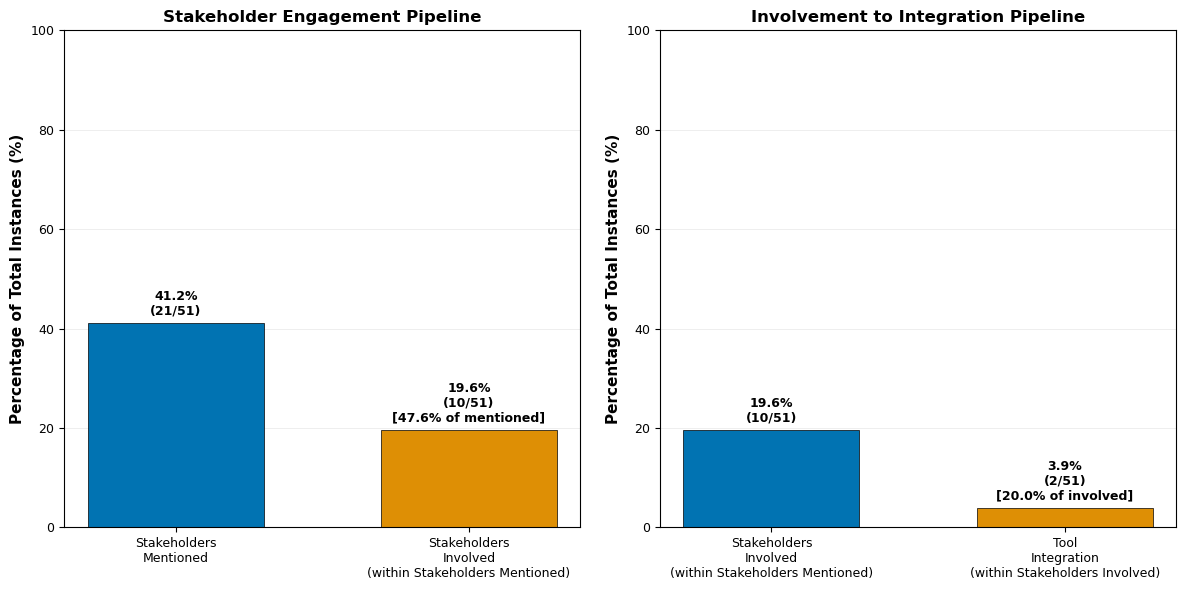

In [9]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

df_filtered = df[df['tool_description'] != 'study']
total_instances = len(df_filtered)

# stakeholders mentioned
stakeholder_mentioned_yes = (df_filtered['stakeholders_mentioned'] == 'Yes').sum()
stakeholder_mentioned_pct = (stakeholder_mentioned_yes / total_instances) * 100

# stakeholders involved WITHIN those mentioned
df_mentioned = df_filtered[df_filtered['stakeholders_mentioned'] == 'Yes']
stakeholder_involved_within_mentioned = (df_mentioned['stakeholders_involved'] == 'Yes').sum()
stakeholder_involved_within_mentioned_pct = (stakeholder_involved_within_mentioned / total_instances) * 100

# tool integration WITHIN stakeholders involved (which are already within mentioned)
df_involved = df_mentioned[df_mentioned['stakeholders_involved'] == 'Yes']
tool_integration_within_involved = (df_involved['tool_integration'] == 'Yes').sum()
tool_integration_within_involved_pct = (tool_integration_within_involved / total_instances) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

categories1 = ['Stakeholders\nMentioned', 'Stakeholders\nInvolved\n(within Stakeholders Mentioned)']
values1 = [stakeholder_mentioned_pct, stakeholder_involved_within_mentioned_pct]
counts1 = [stakeholder_mentioned_yes, stakeholder_involved_within_mentioned]
colors = sns.color_palette("colorblind", n_colors=2)

bars1 = ax1.bar(categories1, values1, color=colors, edgecolor='black', linewidth=0.5, width=0.6)
ax1.set_ylabel('Percentage of Total Instances (%)', fontweight='bold')
ax1.set_title('Stakeholder Engagement Pipeline', fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)
ax1.set_ylim(0, 100)

for i, (bar, pct, count) in enumerate(zip(bars1, values1, counts1)):
    if i == 0:
        label = f'{pct:.1f}%\n({count}/{total_instances})'
    else:
        conditional_pct = (stakeholder_involved_within_mentioned / stakeholder_mentioned_yes * 100) if stakeholder_mentioned_yes > 0 else 0
        label = f'{pct:.1f}%\n({count}/{total_instances})\n[{conditional_pct:.1f}% of mentioned]'
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            label, ha='center', va='bottom', fontweight='bold', fontsize=9)

categories2 = ['Stakeholders\nInvolved\n(within Stakeholders Mentioned)', 'Tool\nIntegration\n(within Stakeholders Involved)']
values2 = [stakeholder_involved_within_mentioned_pct, tool_integration_within_involved_pct]
counts2 = [stakeholder_involved_within_mentioned, tool_integration_within_involved]

bars2 = ax2.bar(categories2, values2, color=colors, edgecolor='black', linewidth=0.5, width=0.6)
ax2.set_ylabel('Percentage of Total Instances (%)', fontweight='bold')
ax2.set_title('Involvement to Integration Pipeline', fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)
ax2.set_ylim(0, 100)

for i, (bar, pct, count) in enumerate(zip(bars2, values2, counts2)):
    if i == 0:
        label = f'{pct:.1f}%\n({count}/{total_instances})'
    else:
        conditional_pct = (tool_integration_within_involved / stakeholder_involved_within_mentioned * 100) if stakeholder_involved_within_mentioned > 0 else 0
        label = f'{pct:.1f}%\n({count}/{total_instances})\n[{conditional_pct:.1f}% of involved]'
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            label, ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig("fig_7_comparative_analysis_stakeholder_involvement_and_integration_pipelines.png")
plt.show()

In [10]:
df_filtered = df[df['tool_description'] != 'study']

tool_counts = df_filtered['tool_description'].value_counts().sort_index()

print("Total proposals per tool description:")
print("="*40)
for tool, count in tool_counts.items():
    print(f"{tool:20s}: {count:3d}")

print("="*40)
print(f"{'Total':20s}: {tool_counts.sum():3d}")

summary_df = pd.DataFrame({
    'Tool Description': tool_counts.index,
    'Count': tool_counts.values,
    'Percentage': (tool_counts.values / tool_counts.sum() *
100).round(1)
})

print("\nSummary Table:")
print(summary_df.to_string(index=False))

Total proposals per tool description:
application         :  13
datasheet           :  13
framework           :  16
markup format       :   5
schema              :   2
toolkit             :   2
Total               :  51

Summary Table:
Tool Description  Count  Percentage
     application     13        25.5
       datasheet     13        25.5
       framework     16        31.4
   markup format      5         9.8
          schema      2         3.9
         toolkit      2         3.9


In [11]:
df_filtered = df[df['tool_description'] != 'study']

automation_counts = df_filtered['degree_automation'].value_counts().sort_index()

print("Total proposals per degree of automation:")
print("="*40)
for automation, count in automation_counts.items():
    print(f"{automation:20s}: {count:3d}")

print("="*40)
print(f"{'Total':20s}: {automation_counts.sum():3d}")

summary_df = pd.DataFrame({
    'Degree of Automation': automation_counts.index,
    'Count': automation_counts.values,
    'Percentage': (automation_counts.values /
automation_counts.sum() * 100).round(1)
})

print("\nSummary Table:")
print(summary_df.to_string(index=False))

Total proposals per degree of automation:
Automated           :   9
Hybrid              :  17
Manual              :  25
Total               :  51

Summary Table:
Degree of Automation  Count  Percentage
           Automated      9        17.6
              Hybrid     17        33.3
              Manual     25        49.0


In [12]:
df_filtered = df[df['tool_description'] != 'study']
total = len(df_filtered)

# Calculate flows
mentioned_yes = (df_filtered['stakeholders_mentioned'] == 'Yes').sum()
mentioned_no = (df_filtered['stakeholders_mentioned'] == 'No').sum()

df_mentioned = df_filtered[df_filtered['stakeholders_mentioned'] == 'Yes']
involved_yes = (df_mentioned['stakeholders_involved'] == 'Yes').sum()
involved_no = (df_mentioned['stakeholders_involved'] == 'No').sum()

df_involved = df_mentioned[df_mentioned['stakeholders_involved'] == 'Yes']
integrated_yes = (df_involved['tool_integration'] == 'Yes').sum()
integrated_no = (df_involved['tool_integration'] == 'No').sum()

# Define nodes
labels = [
    f'All Tools\n(n={total})',
    f'Stakeholders\nMentioned\n(n={mentioned_yes})',
    f'Stakeholders\nNot Mentioned\n(n={mentioned_no})',
    f'Stakeholders\nInvolved\n(n={involved_yes})',
    f'Stakeholders\nNot Involved\n(n={involved_no})',
    f'Tool\nIntegrated\n(n={integrated_yes})',
    f'Tool\nNot Integrated\n(n={integrated_no})'
]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = labels,
        color = ["#0173B2", "#56B4E9", "#CC79A7", "#56B4E9", "#CC79A7", "#56B4E9", "#CC79A7"],
        hovertemplate='%{label}<extra></extra>'
    ),
    link = dict(
        source = [0, 0, 1, 1, 3, 3],
        target = [1, 2, 3, 4, 5, 6],
        value = [mentioned_yes, mentioned_no, involved_yes, involved_no, integrated_yes, integrated_no],
        color = ["rgba(86, 180, 233, 0.4)", "rgba(204, 121, 167, 0.4)",
                "rgba(86, 180, 233, 0.4)", "rgba(204, 121, 167, 0.4)",
                "rgba(86, 180, 233, 0.4)", "rgba(204, 121, 167, 0.4)"],
        hovertemplate='Count: %{value}<br>%{source.label} → %{target.label}<extra></extra>'
    )
)])

fig.update_layout(
    title_text="Stakeholder Engagement and Integration Pipeline",
    title_font_size=14,
    title_font_family="Arial",
    title_x=0.5,
    font_size=11,
    height=500,
    margin=dict(l=10, r=10, t=50, b=10)
)

fig.write_html("fig_8_stakeholder_integration_sankey.html")
fig.show()

# Print summary statistics
print(f"Pipeline Statistics:")
print(f"{'='*50}")
print(f"Total tools: {total}")
print(f"Stakeholders mentioned: {mentioned_yes} ({mentioned_yes/total*100:.1f}%)")
print(f"Stakeholders involved (of mentioned): {involved_yes} ({involved_yes/mentioned_yes*100:.1f}% if mentioned_yes > 0 else 0)")
print(f"Tool integrated (of involved): {integrated_yes} ({integrated_yes/involved_yes*100:.1f}% if involved_yes > 0 else 0)")
print(f"{'='*50}")
print(f"Drop-off rates:")
print(f"  Not mentioned: {mentioned_no} ({mentioned_no/total*100:.1f}%)")
print(f"  Mentioned but not involved: {involved_no} ({involved_no/mentioned_yes*100:.1f}% if mentioned_yes > 0 else 0)")
print(f"  Involved but not integrated: {integrated_no} ({integrated_no/involved_yes*100:.1f}% if involved_yes > 0 else 0)")

Pipeline Statistics:
Total tools: 51
Stakeholders mentioned: 21 (41.2%)
Stakeholders involved (of mentioned): 10 (47.6% if mentioned_yes > 0 else 0)
Tool integrated (of involved): 2 (20.0% if involved_yes > 0 else 0)
Drop-off rates:
  Not mentioned: 30 (58.8%)
  Mentioned but not involved: 11 (52.4% if mentioned_yes > 0 else 0)
  Involved but not integrated: 8 (80.0% if involved_yes > 0 else 0)


In [25]:
import plotly.graph_objects as go
import plotly.io as pio

df_filtered = df[df['tool_description'] != 'study']
total_instances = len(df_filtered)

# Calculate flows
mentioned_yes = (df_filtered['stakeholders_mentioned'] == 'Yes').sum()
mentioned_no = (df_filtered['stakeholders_mentioned'] == 'No').sum()

df_mentioned = df_filtered[df_filtered['stakeholders_mentioned'] == 'Yes']
involved_yes = (df_mentioned['stakeholders_involved'] == 'Yes').sum()
involved_no = (df_mentioned['stakeholders_involved'] == 'No').sum()

df_involved = df_mentioned[df_mentioned['stakeholders_involved'] == 'Yes']
integrated_yes = (df_involved['tool_integration'] == 'Yes').sum()
integrated_no = (df_involved['tool_integration'] == 'No').sum()

# Define node labels with counts and percentages
labels = [
    f'All Tools<br>n={total_instances}',  # 0
    f'Stakeholders<br>Mentioned<br>n={mentioned_yes}<br>({mentioned_yes/total_instances*100:.1f}%)',  # 1
    f'Stakeholders<br>Not Mentioned<br>n={mentioned_no}<br>({mentioned_no/total_instances*100:.1f}%)',  # 2
    f'Stakeholders<br>Involved<br>n={involved_yes}<br>({involved_yes/total_instances*100:.1f}%)',  # 3
    f'Stakeholders<br>Not Involved<br>n={involved_no}<br>({involved_no/total_instances*100:.1f}%)',  # 4
    f'Stakeholder input<br>Integrated<br>n={integrated_yes}<br>({integrated_yes/total_instances*100:.1f}%)',  # 5
    f'Stakeholder input<br>not Integrated<br>n={integrated_no}<br>({integrated_no/total_instances*100:.1f}%)'  # 6
]

# Create custom link labels showing counts and percentages
link_labels = [
    f'{mentioned_yes} ({mentioned_yes/total_instances*100:.1f}%)',  # All → Mentioned
    f'{mentioned_no} ({mentioned_no/total_instances*100:.1f}%)',  # All → Not Mentioned
    f'{involved_yes} ({involved_yes/mentioned_yes*100:.1f}%)',  # Mentioned → Involved
    f'{involved_no} ({involved_no/mentioned_yes*100:.1f}%)',  # Mentioned → Not Involved
    f'{integrated_yes} ({integrated_yes/involved_yes*100:.1f}%)',  # Involved → Integrated
    f'{integrated_no} ({integrated_no/involved_yes*100:.1f}%)'  # Involved → Not Integrated
]

# Create Sankey diagram with accessible grayscale-friendly colors
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color='black', width=2),
        label=labels,
        # Grayscale-accessible colors: dark for start, medium-dark for positive outcomes, light grays for negative outcomes
        color=['#2c3e50',  # All Tools - very dark
                '#546e7a',  # Mentioned - medium-dark
                '#969696',  # Not Mentioned - medium-light gray
                '#546e7a',  # Involved - medium-dark
                '#bdbdbd',  # Not Involved - light gray
                '#546e7a',  # Integrated - medium-dark
                '#d9d9d9'],  # Not Integrated - very light gray
        customdata=labels,
        hovertemplate='%{customdata}<extra></extra>',
        x=[0.05, 0.35, 0.35, 0.65, 0.65, 0.95, 0.95],
        y=[0.5, 0.8, 0.2, 0.85, 0.55, 0.9, 0.7]
    ),
    link=dict(
        source=[0, 0, 1, 1, 3, 3],
        target=[1, 2, 3, 4, 5, 6],
        value=[mentioned_yes, mentioned_no, involved_yes, involved_no, integrated_yes, integrated_no],
        # Accessible link colors with transparency
        color=['rgba(84, 110, 122, 0.4)',   # Mentioned - medium-dark with transparency
                'rgba(150, 150, 150, 0.4)',  # Not Mentioned - medium-light gray with transparency
                'rgba(84, 110, 122, 0.4)',   # Involved - medium-dark with transparency
                'rgba(189, 189, 189, 0.4)',  # Not Involved - light gray with transparency
                'rgba(84, 110, 122, 0.4)',   # Integrated - medium-dark with transparency
                'rgba(217, 217, 217, 0.4)'], # Not Integrated - very light gray with transparency
        customdata=link_labels,
        hovertemplate='%{customdata}<extra></extra>'
    )
)])

fig.update_layout(
    title={
        'text': '',
        'font': {'size': 18, 'family': 'Arial', 'color': 'black'},
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(size=12, family='Arial', color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=650,  # Increased height to accommodate bottom labels
    width=1200,
    margin=dict(l=20, r=20, t=80, b=100)  # Increased bottom margin for stage labels
)

# Add annotations for stage labels with more space at the bottom
annotations = [
    dict(x=0.05, y=-0.12, text='<b>Start</b>', showarrow=False,
        xref='paper', yref='paper', font=dict(size=12, color='black')),
    dict(x=0.35, y=-0.12, text='<b>Stage 1: Mention</b>', showarrow=False,
        xref='paper', yref='paper', font=dict(size=12, color='black')),
    dict(x=0.65, y=-0.12, text='<b>Stage 2: Involvement</b>', showarrow=False,
        xref='paper', yref='paper', font=dict(size=12, color='black')),
    dict(x=0.95, y=-0.12, text='<b>Stage 3: Integration</b>', showarrow=False,
        xref='paper', yref='paper', font=dict(size=12, color='black'))
]

fig.update_layout(annotations=annotations)

# Save as interactive HTML and static image
fig.write_html("fig_7_stakeholder_integration_sankey.html")
fig.write_image("fig_7_stakeholder_integration_sankey.png", width=1200, height=650, scale=2)

fig.show()

# Print summary statistics
print(f"Pipeline Statistics:")
print(f"{'='*60}")
print(f"Total tools: {total_instances}")
print(f"Stakeholders mentioned: {mentioned_yes} ({mentioned_yes/total_instances*100:.1f}%)")
print(f"Stakeholders involved (of mentioned): {involved_yes} ({involved_yes/mentioned_yes*100:.1f}% of mentioned)")
print(f"Stakeholder input integrated (of involved): {integrated_yes} ({integrated_yes/involved_yes*100:.1f}% of involved)")
print(f"{'='*60}")
print(f"Drop-off rates:")
print(f"  Not mentioned: {mentioned_no} ({mentioned_no/total_instances*100:.1f}%)")
print(f"  Mentioned but not involved: {involved_no} ({involved_no/mentioned_yes*100:.1f}% of mentioned)")
print(f"  Involved but not integrated: {integrated_no} ({integrated_no/involved_yes*100:.1f}% of involved)")

Pipeline Statistics:
Total tools: 51
Stakeholders mentioned: 21 (41.2%)
Stakeholders involved (of mentioned): 10 (47.6% of mentioned)
Stakeholder input integrated (of involved): 2 (20.0% of involved)
Drop-off rates:
  Not mentioned: 30 (58.8%)
  Mentioned but not involved: 11 (52.4% of mentioned)
  Involved but not integrated: 8 (80.0% of involved)
